## Krusell-Smith (1998)

- Author: yuxuan zhao
- Last Update: 2024/4/30

##  Model
Aggregate shock to TFP
Incomplete market: borrowing constraint
Heterogeneous agent

Difficulty: need to solve value function of an infinite-dimensional state space

Optimization problem can therefore be expressed as:
$$
v(k, \epsilon; \Gamma, z)=\max_{k'}u(c)+\beta Ev[(k', \epsilon'; \Gamma', z')|\epsilon,z]
$$
subject to
$$
c+k'=r(\bar{k},\bar{l},z)k+w(\bar{k},\bar{l},z)\epsilon\tilde{l}+(1-\delta)k, \\
\Gamma'=H(\Gamma,z,z'),\\
k'\ge 0 .
$$

The decision rule for the updating of capital implied by this problem is denoted by the function $f$: $k'= f(k, \epsilon; \Gamma, z)$.

A recursive competitive equilibrium is then a law of motion $H$, a pair of individual functions $v$ and $f$, and pricing functions $(r, w)$ such that
- $(v, f)$ solves the consumer’s problem
- $r$ and $w$ are competitive 
- $H$ is generated by $f$.

## KS98 Solution Algorithm

This problem is extremely hard to solve since value function is infinite-dimensional

KS98 assumed bounded rationality. That is, assume agents perceive distribution as being summarized by its moments:

$$\log{\bar{k}^{\prime}}  = a_0 + a_1 \log{\bar{k}}$$



The agent then solves the following problem:
$$
v(\epsilon, k ; z, \bar{k})=\max _{c, k^{\prime}} u(c)+\beta E v\left[\left(\epsilon^{\prime}, k^{\prime} ; z, \bar{k}^{\prime}\right) \mid \epsilon, z\right]
$$
subject to
$$
\begin{gathered}
c+k^{\prime}=r(\bar{k}, \bar{l}, z) k+w(\bar{k}, \bar{l}, z) \epsilon \tilde{l}+(1-\delta) k \\
\log \left(\bar{k}^{\prime}\right)=a_0(z)+a_1(z) \log (\bar{k}) \\
\log \left(\bar{k}^{\prime}\right)=b_0(z)+b_1(z) \log (\bar{k}) \\
k^{\prime} \geq 0
\end{gathered}
$$


1. Guess for $a_0$ and $a_1$. We can start with $a_0 = 0, a_1 = 1$
2. Solve the DP problem to get policy function $a' = g(a, e, z, K)$
3. Use this policy function and simulate the savings behaviour of long (T=1000) panel of many individuals (a continuum)
4. Regress $\log{\bar{k}_{t+1}}$ on $\log{\bar{k}_t}$ + constant conditional on $z_t$.
5. Check if regression coefficients match guess. If yes, stop. If not, update guess and repeat starting on 1.
6. Once convergence is achieved, check approximate aggregation assumption.

In [52]:
# Import all libraries
import numpy as np
from numpy.random import randn
import statsmodels.api as sm
from scipy.interpolate import RectBivariateSpline, interpn, interp1d
np.set_printoptions(precision=4, suppress=True)
import pickle
import quantecon as qe
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import copy
plt.style.use({'figure.facecolor':'white'})
%config InlineBackend.figure_format = 'retina'
from itertools import cycle

## Step1 Initialize parameters

In [53]:
# Guess PLM (peceived law of motion)

a0_b, a0_g, a1_b, a1_g = 0, 0, 1, 1
B = np.array([[a0_b, a1_b],[a0_g, a1_g]])

# Initialize parameters

beta = 0.99  # discount factor
gamma = 1  # utility function parameter
alpha = 0.36  # share of capital in production function
delta = 0.025  # depreciation rate
mu = 0  # unemployment benefits as a share of the wage
l_bar = 0.2  # time endowment; normalizes labor supply to 1 in bad state
z_g = 1.01 # aggragate shock value in good state
z_b = 0.99 # aggragate shock value in bad state

# precision
# Policy function iteration may require higher precision compared to value function iteration.
tolv = 1e-05
tola = 1e-07



## Step 2: Creation of the grids

#### Choice of a grid in the ($k$, $\bar{k}$)

The steady state capital satisfies the following condition：

$$
r_{ss}-(1-\delta)=\alpha z_{ss} (\frac{k_{ss}}{l_{ss}})^{\alpha-1}
$$

Normalize $l_{ss}$ to 1 , then steady state capital $k_{ss}$ is: 

$$
k_{ss} = \{\frac{\frac{1}{\beta}-(1-\delta)}{\alpha}\}^{\frac{1}{\alpha-1}}
$$

Based on the value of $k_ss$, we pin down the aggregate capital grid.

We want more gridpoints where policy function is more nonlinear in assets, so we use double-exponential transformation of a uniformly spaced grid:

$$
k_i = \underline{k}+e^{e^{u_i}-1}-1
$$

$u_i$ is on a uniform inteval $[0,\bar{u}]$ , which means

$$
\bar{u} = log(1+log(1+\bar{k}-\underline{k}))
$$

In [54]:
k_ss = ((1/beta-(1-delta))/alpha)**(1/(alpha-1))
print(f'Steady state capital is {k_ss}')

Steady state capital is 37.98925353815222


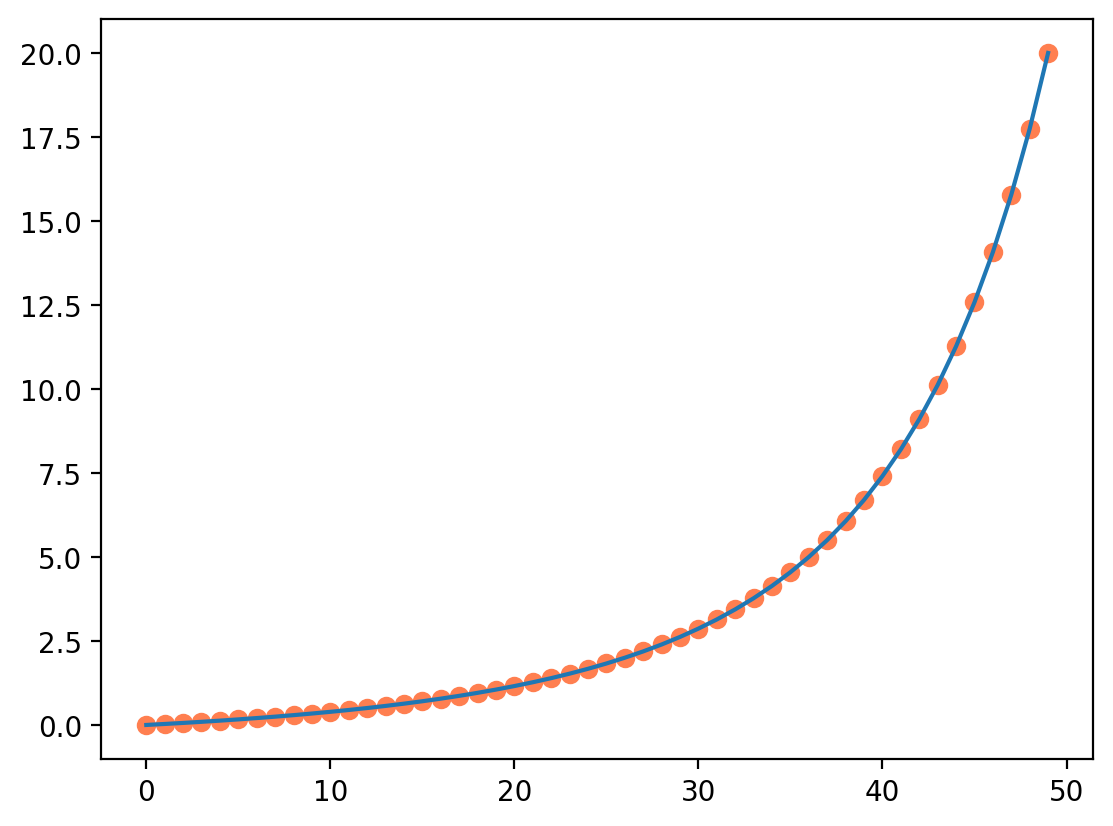

In [55]:
# Grid for all state variables:
Kgrid_size = 10 # aggregate capital grid
Zgrid_size = 2 # aggregate shock grid
egrid_size = 2 # labor endowment grid
agrid_size = 50 # individual asset grid


Kgrid = np.linspace(30,50,Kgrid_size)
phi = 0
zgrid = np.array([z_b, z_g])
egrid = np.array([mu, 1])

# individual asset state space
amax=20
amin=0
ubar=np.log(1 + np.log(1 + amax - amin))
ugrid= np.linspace(0,ubar,agrid_size)
agrid=amin+np.exp(np.exp(ugrid)-1)-1


indices = np.arange(len(agrid)) # create an array of indices
plt.plot(indices, agrid)
plt.scatter(indices, agrid, c = 'coral') 
# in the k direction, we havr a state sapce with many grid points near zero (where there is a lot of curvature) and fewer grid points for larger values of k (where there is less curvature).

## Step 3: Construction of trasition matrix

Create transition matrices for aggregate shock, idiosyncratic shock, and shock state

We use $\pi_{s^{\prime} \epsilon^{\prime} \in}$ to denote the probability of transition from state $\left(z_s, \epsilon\right)$ today to $\left(z_{s^{\prime}}, \epsilon^{\prime}\right)$ tomorrow. The transition probabilities have to satisfy the restrictions

\begin{align*}
\pi_{s^{\prime} 00}+\pi_{s^{\prime} 01}=\pi_{s^{\prime} 10}+\pi_{s^{\prime} 11}&=\pi_{s s^{\prime}} \\

u_s \frac{\pi_{s s^{\prime} 00}}{\pi_{s s^{\prime}}}+\left(1-u_s\right) \frac{\pi_{s s^{\prime} 10}}{\pi_{s s^{\prime}}}&=u_{s^{\prime}} \\

\pi_{g b 00} \pi_{g b}^{-1}=1.25 \pi_{b b 0} \pi_{b b}^{-1} , \pi_{b g 00} \pi_{b g}^{-1}&=0.75 \pi_{g 000} \pi_{g g}^{-1}
\end{align*}

We also have the estrictions between duration $D$ and transfer probability $P$:

\begin{align*}
D = P*(1-P)+P^2*(1-P)+P^3*(1-P)+...... = \frac{1}{1-P}
\end{align*}

which means:

\begin{align*}
P= 1-\frac{1}{D}
\end{align*}


##### Arguments
- `ug::Real`: unemployment rate in good state
- `ub::Real`: unemployment rate in bad state
- `zg_ave_dur::Real`: average duration of good state
- `zb_ave_dur::Real`: average duration of bad state
- `ug_ave_dur::Real`: average duration of unemployment in good state
- `ub_ave_dur::Real`: average duration of unemployment in bad state
- `puu_rel_gb2bb::Real`: prob. of u to u cond. on g to b relative to that of b to b 
- `puu_rel_bg2gg::Real`: prob. of u to u cond. on b to g relative to that of g to g

In [56]:
ug=0.04
ub=0.1
zg_ave_dur=8
zb_ave_dur=8
ug_ave_dur=1.5
ub_ave_dur=2.5
puu_rel_gb2bb=1.25
puu_rel_bg2gg=0.75
    
# probability of remaining in good state
pgg = 1-1/zg_ave_dur
# probability of remaining in bad state
pbb = 1-1/zb_ave_dur
# probability of changing from g to b
pgb = 1-pgg
# probability of changing from b to g
pbg = 1-pbb  
    
# prob. of 0 to 0 cond. on g to g
p00_gg = 1-1/ug_ave_dur
# prob. of 0 to 0 cond. on b to b
p00_bb = 1-1/ub_ave_dur
# prob. of 0 to 1 cond. on g to g
p01_gg = 1-p00_gg
# prob. of 0 to 1 cond. on b to b
p01_bb = 1-p00_bb
    
# prob. of 0 to 0 cond. on g to b
p00_gb=puu_rel_gb2bb*p00_bb
# prob. of 0 to 0 cond. on b to g
p00_bg=puu_rel_bg2gg*p00_gg
# prob. of 0 to 1 cond. on g to b
p01_gb=1-p00_gb
# prob. of 0 to 1 cond. on b to g
p01_bg=1-p00_bg
    
# prob. of 1 to 0 cond. on  g to g
p10_gg=(ug - ug*p00_gg)/(1-ug)
# prob. of 1 to 0 cond. on b to b
p10_bb=(ub - ub*p00_bb)/(1-ub)
# prob. of 1 to 0 cond. on g to b
p10_gb=(ub - ug*p00_gb)/(1-ug)
# prob. of 1 to 0 cond on b to g
p10_bg=(ug - ub*p00_bg)/(1-ub)
# prob. of 1 to 1 cond. on  g to g
p11_gg= 1-p10_gg
# prob. of 1 to 1 cond. on b to b
p11_bb= 1-p10_bb
# prob. of 1 to 1 cond. on g to b
p11_gb= 1-p10_gb
# prob. of 1 to 1 cond on b to g
p11_bg= 1-p10_bg


# transition matrix of shocks, states are ordered as (good, employed), (bad, employed), (good, unemployed), (bad, unemployed)

prob=np.array(([pbg*p01_bg, pbb*p01_bb, pbg*p00_bg, pbb*p00_bb],
                 [pgg*p01_gg, pgb*p01_gb, pgg*p00_gg, pgb*p00_gb],
                 [pbg*p11_bg, pbb*p11_bb, pbg*p10_bg, pbb*p10_bb],
                 [pgg*p11_gg, pgb*p11_gb, pgg*p10_gg, pgb*p10_gb]))

print(prob)

# Transition probabilities between aggregate states
prob_ag = np.zeros((2, 2))
prob_ag[0, 0] = prob[0, 0]+prob[0, 1]
prob_ag[1, 0] = 1-prob_ag[0, 0] # bad state to good state
prob_ag[1, 1] = prob[2, 2]+prob[2, 3]
prob_ag[0, 1] = 1-prob_ag[1, 1]

print(prob_ag)


[[0.0938 0.35   0.0312 0.525 ]
 [0.5833 0.0312 0.2917 0.0938]
 [0.1229 0.8361 0.0021 0.0389]
 [0.8507 0.1159 0.0243 0.0091]]
[[0.4438 0.959 ]
 [0.5562 0.041 ]]


## Step 4 Solve the DP problem : VFI method

The agent then solves the following problem:
$$
v(\epsilon, k ; z, \bar{k})=\max _{c, k^{\prime}} u(c)+\beta E v\left[\left(\epsilon^{\prime}, k^{\prime} ; z, \bar{k}^{\prime}\right) \mid \epsilon, z\right]
$$
subject to
$$
\begin{gathered}
c+k^{\prime}=r(\bar{k}, \bar{l}, z) k+w(\bar{k}, \bar{l}, z) \epsilon \tilde{l}+(1-\delta) k \\
\log \left(\bar{k}^{\prime}\right)=a_0(z)+a_1(z) \log (\bar{k}) \\
\log \left(\bar{k}^{\prime}\right)=b_0(z)+b_1(z) \log (\bar{k}) \\
k^{\prime} \geq 0
\end{gathered}
$$

In [63]:
r = alpha*zgrid.reshape((Zgrid_size,1))*(Kgrid/(l_bar))**(alpha-1)
w = (1-alpha)*zgrid.reshape((Zgrid_size,1))*(Kgrid/(l_bar))**alpha
# r,w = zgrid_size x Kgrid_size

c = np.ones((agrid_size*agrid_size, egrid_size, Zgrid_size, Kgrid_size))


# Solve the problem of the households using Dynamic Programming
# r,w = zgrid_size x Kgrid_size
for m in range(egrid_size):
    for l in range(Zgrid_size):
        for t in range(Kgrid_size):
            for i in range(agrid_size):
                for j in range(agrid_size):
                    c[i*agrid_size+j,m,l,t] = (r[l,t]+1-delta)*agrid[i]+w[l,t]*egrid[m]*l_bar-agrid[j]
                    if c[i*agrid_size+j,m,l,t] <= 0:
                        c[i*agrid_size+j,m,l,t] = 1e-07
# print(c)

# utility function
if gamma == 1:
        u = np.log(c)
else:
        u = (np.power(c,(1-gamma)-1))/(1-gamma)

pola = np.zeros((agrid_size, egrid_size, Zgrid_size, Kgrid_size))
polc = np.ones((agrid_size, egrid_size, Zgrid_size, Kgrid_size))

# iterate on the value function and compute the optimal policy
V0 = np.zeros((agrid_size, egrid_size, Zgrid_size, Kgrid_size))
V1 = np.ones((agrid_size, egrid_size, Zgrid_size, Kgrid_size))
Kp = 0 # aggregate capital in next period
ap = copy.deepcopy(agrid) # individual capital in next period
trans = np.zeros((egrid_size, Zgrid_size))

#print(Vge.shape)
#print(u[1*agrid_size:(1+1)*agrid_size,0,0,0].shape)

In [64]:
# Value function iteration
iter = 0
metric = 1
metric_V = np.array([])
while np.linalg.norm(V1-V0) > tolv:
    # print(np.linalg.norm(V1-V0))
    iter = iter + 1
    V0 = copy.deepcopy(V1)

    for m in range(egrid_size):
        for l in range(Zgrid_size):
            for t in range(Kgrid_size):
                for i in range(agrid_size):
                    trans=np.reshape(prob[2*m+l],(2,2))
                    Kp = np.exp(B[l,0]+B[l,1]*np.log(Kgrid[t]))

                    Vge_int = RectBivariateSpline(agrid, Kgrid, V0[:,1,1,:]) # good state , employment
                    Vgu_int = RectBivariateSpline(agrid, Kgrid, V0[:,0,1,:]) # good state , unemployment
                    Vbe_int = RectBivariateSpline(agrid, Kgrid, V0[:,1,0,:]) # bad state , employment
                    Vbu_int = RectBivariateSpline(agrid, Kgrid, V0[:,0,0,:]) # bad state , unemployment
                    Vge = np.ravel(Vge_int(ap,Kp)) #Flatten the (50,1) two-dimensional array into a (50,) one-dimensional array.
                    Vgu = np.ravel(Vgu_int(ap,Kp))
                    Vbe = np.ravel(Vbe_int(ap,Kp))
                    Vbu = np.ravel(Vbu_int(ap,Kp))

                    vtemp = u[i*agrid_size:(i+1)*agrid_size,m,l,t]+beta * (Vge*trans[0,0]+Vgu*trans[1,0]+Vbe*trans[0,1]+Vbu*trans[1,1])
                    V1[i,m,l,t] = np.max(vtemp)
                    pola[i,m,l,t] = np.argmax(vtemp)

    metric = np.linalg.norm(V1-V0)
    iter +=1
    if iter % 50 == 0:
        print(iter, metric)
        metric_V = np.append(metric_V, metric)


50 8.86670187647734
100 6.888200278220697
150 5.362248262796332
200 4.167015755389373
250 3.2417097570956552
300 2.521450399106159
350 1.9612361246487557
400 1.5254914337936245
450 1.1865599149609567
500 0.9229316290157589
550 0.7178759349816368
600 0.5583792360349845
650 0.4343192963471373
700 0.33782282551353504
750 0.26276580937627475
800 0.2043848590530893
850 0.15897490890928812
900 0.12365407975821271
950 0.09618078441277772
1000 0.07481146848002383
1050 0.05818995811176775
1100 0.04526139232188656
1150 0.035205277704116925
1200 0.027383416961833384
1250 0.021299406606228255
1300 0.016567133400889937
1350 0.012886270223207763
1400 0.010023216222600634
1450 0.00779627166783734
1500 0.0060641066269013335
1550 0.004716791660067727
1600 0.0036688213010472046
1650 0.0028536875717513825
1700 0.0022196591463799673
1750 0.0017264982946450077
1800 0.0013429072505251835
1850 0.0010445419431907045
1900 0.0008124670341769679
1950 0.0006319542129855814
2000 0.000491547485040745
2050 0.0003823

## Step 4 : solve the DP problem : Euler equation method
Due to the time-consuming nature of VFI (The program took 15 minutes to converge, which might be because I included too many loop structures in VFI algorithm)

we opted for policy function iteration.

Compared to VFI, policy function iteration exhibits gradient convergence.

Euler equation:

$$\left(c\right)^{-\gamma}=\beta E\left[\left(c'\right)^{-\gamma}(1-\delta+r')\right].$$

In [65]:
prob = np.array(([0.525, 0.35, 0.03125, 0.09375],
                 [0.038889, 0.836111, 0.002083, 0.122917],
                 [0.09375, 0.03125, 0.291667, 0.583333],
                 [0.009115, 0.115885, 0.024306, 0.850694]))

# Transition probabilities between aggregate states
prob_ag = np.zeros((2, 2))
prob_ag[0, 0] = prob[0, 0]+prob[0, 1]
prob_ag[1, 0] = 1-prob_ag[0, 0] # bad state to good state
prob_ag[1, 1] = prob[2, 2]+prob[2, 3]
prob_ag[0, 1] = 1-prob_ag[1, 1]


g = np.zeros((egrid_size, Zgrid_size, Kgrid_size))
g = g.tolist()

a1 = np.ones((agrid_size, egrid_size, Zgrid_size, Kgrid_size))
a0 = np.zeros((agrid_size, egrid_size, Zgrid_size, Kgrid_size))

for i in range(egrid_size):
    for j in range(Zgrid_size):
        for k in range(Kgrid_size):
            a1[:, i,j,k] = copy.deepcopy(agrid)


Kp = np.zeros((Zgrid_size,Kgrid_size))
Kp[0,:] = np.exp(B[0,0] + B[0,1]*np.log(Kgrid))
Kp[1,:] = np.exp(B[1,0] + B[1,1]*np.log(Kgrid))

r1 = alpha*zgrid.reshape((Zgrid_size,1))*(Kp/(l_bar))**(alpha-1)
w1 = (1-alpha)*zgrid.reshape((Zgrid_size,1))*(Kp/(l_bar))**alpha

iter = 0
metric = 1
metric_P = np.array([])
while  np.linalg.norm(a1-a0) > tola:

    a0 = copy.deepcopy(a1)
    
    for i in range(egrid_size):
        for j in range(Zgrid_size):
            for l in range(Kgrid_size):
                g[i][j][l] = interp1d(a1[:,i,j,l], agrid,  kind='linear', fill_value = 'extrapolate')


    for i,e in enumerate(egrid):
        for j,z in enumerate(zgrid):
            for l,K in enumerate(Kgrid):
                r = alpha*z*(K/(l_bar))**(alpha-1)
                w = (1-alpha)*z*(K/(l_bar))**alpha
                E = 0
                for o in range(4):
                    E += prob[i+j*2,o]*(agrid*(1+r1[o//2,l])+egrid[o % 2]*w1[o // 2,l]-np.maximum(g[o % 2][o // 2][l](agrid),phi))**(-gamma)
                E = beta*(1+r1[j,l])*E
                a1[:,i,j,l] = (E**(-1/gamma)-e*w+agrid)/(1+r)

    metric = np.linalg.norm(a1-a0)

    iter +=1
    if iter % 50 == 0:
        print(iter, metric)
        metric_P = np.append(metric_P, metric)

C:\Users\86132\AppData\Local\Temp\ipykernel_15128\3923352226.py:53: RuntimeWarning: divide by zero encountered in reciprocal
  E += prob[i+j*2,o]*(agrid*(1+r1[o//2,l])+egrid[o % 2]*w1[o // 2,l]-np.maximum(g[o % 2][o // 2][l](agrid),phi))**(-gamma)


50 0.17398612167996
100 0.02630616348145691
150 0.005001271476508194
200 0.0011104684585554535
250 0.0002842420916808463
300 8.055689927725308e-05
350 2.4407481432757397e-05
400 7.725224783143682e-06
450 2.5175280289565734e-06
500 8.369397570757841e-07
550 2.821175095543125e-07


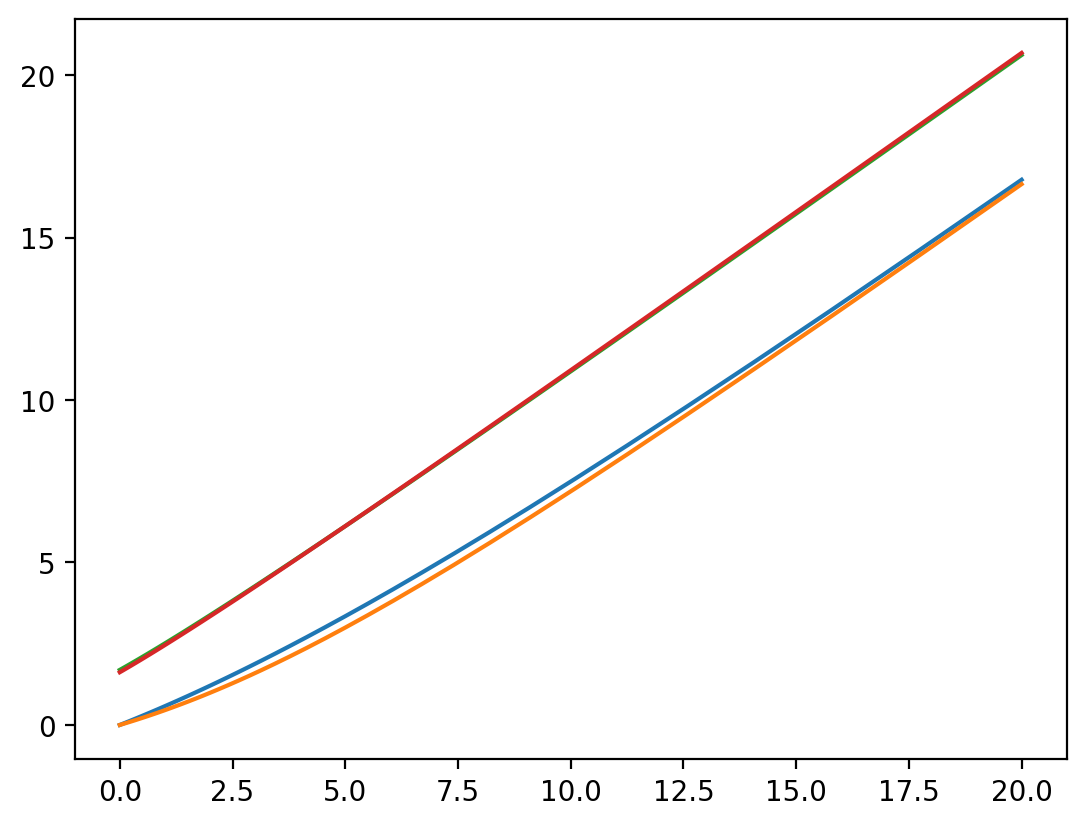

In [68]:
# plot the policy function
for m in range(egrid_size):
        for l in range(Zgrid_size): 
            plt.plot(agrid, np.maximum(g[m][l][4](agrid),phi))

plt.show()

## Convergence speed of two algorithms

We have a comparison of the convergence speeds of two algorithms here, indicating that PFI converges significantly faster than VFI

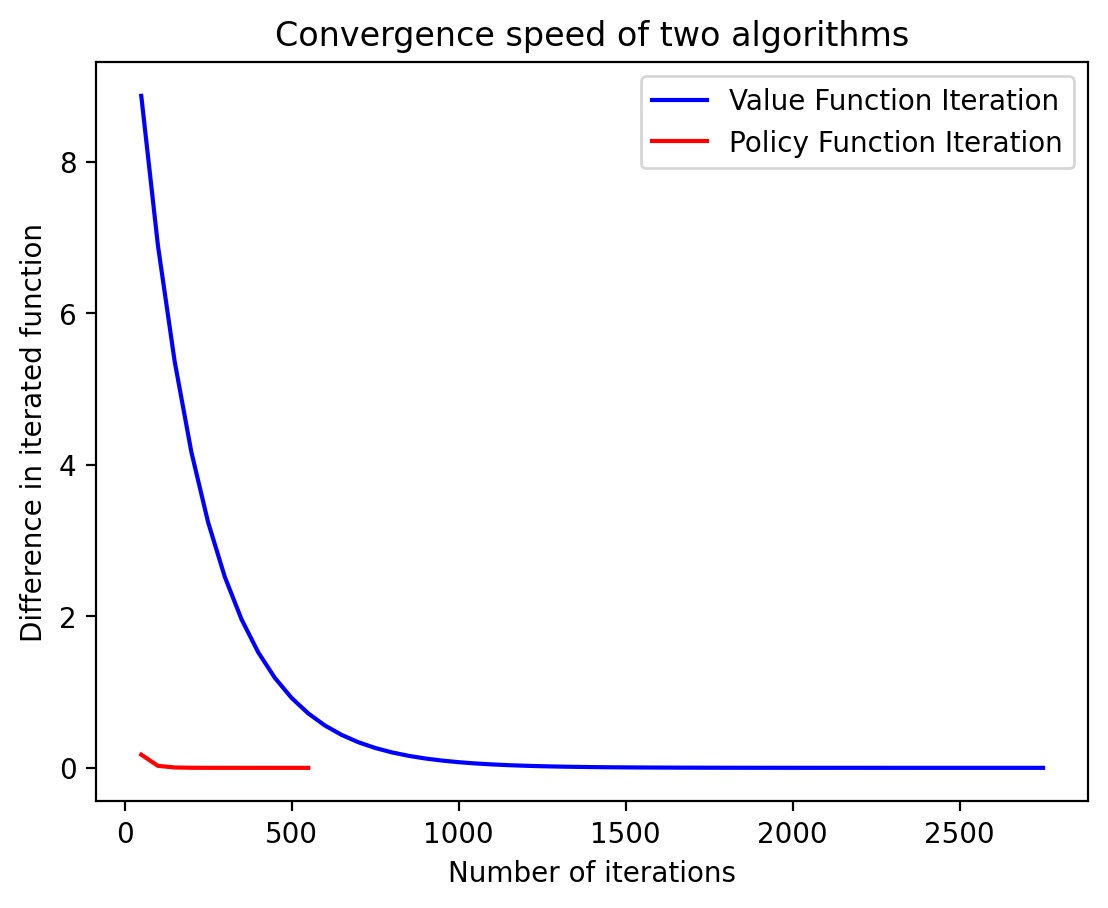

In [67]:
# Convergence speed of two algorithms

inc_V=np.arange(len(metric_V))*50+50
inc_P=np.arange(len(metric_P))*50+50
plt.plot(inc_V, metric_V, label='Value Function Iteration', color='blue')
plt.plot(inc_P, metric_P, label='Policy Function Iteration', color='red')

plt.legend()
plt.title('Convergence speed of two algorithms')

plt.xlabel('Number of iterations')
plt.ylabel('Difference in iterated function')

# 显示图形
plt.show()

## Step 5 Simulation


- We use consumers’ decision rules to simulate the behavior of N (N=500) agents (with N a large number) over a large number, T (T=1000), of time periods. 

- Then we use the simulated data to estimate parameters of ALM. If the estimation ALM are very close to those guessed PLM, stop.

- it is important to ensure that simulations of the economy’s behavior impose the law of large numbers (or at least its first-moment implications).

    To accomplish this task in the simulated data, we first update the employment status of each agent according to the appropriate conditional probabilities.We then check to see whether the fraction of unemployed agents matches the desired number



In [69]:
# Simulation
N_agents = 500
T = 1000
ag_shock = np.zeros((T, 1))
id_shock = np.zeros((T, N_agents))
np.random.seed(1234)


P = prob/np.kron(prob_ag, np.ones((2, 2)))
# generate aggregate shocks
mc = qe.MarkovChain(prob_ag)
ag_shock = mc.simulate(ts_length=T, init=0)  # start from bad state

# generate idiosyncratic shocks for all agents in the first period
draw = np.random.uniform(size=N_agents)

#set state to good if probability exceeds ur_b, ensure the model's unemployment rate matchs the data.
id_shock[0, :] = draw>0.1

# generate idiosyncratic shocks for all agents starting in second period
draw = np.random.uniform(size=(T-1, N_agents))
for t in range(1, T):
    # Fix idiosyncratic transition matrix conditional on aggregate state
    transition = P[2*ag_shock[t-1]: 2*ag_shock[t-1]+2, 2*ag_shock[t]: 2*ag_shock[t]+2]
    transition_prob = [transition[int(id_shock[t-1, i]), int(id_shock[t-1, i])] for i in range(N_agents)]
    check = transition_prob>draw[t-1, :] #sign whether to remain in current state
    id_shock[t, :] = id_shock[t-1, :]*check + (1-id_shock[t-1, :])*(1-check)


In [70]:
Ks =np.zeros(T)
Ks[0] = k_ss
a1s = np.zeros((N_agents, T))
a0s = k_ss*np.ones(N_agents)
a1s[:,0] = a0s.copy()
K = interp1d(Kgrid, Kgrid, kind='nearest', fill_value='extrapolate')
# compute K_t+1
for t in range(1,T):
    for i in range(N_agents):
        a1s[i, t] = g[int(id_shock[t-1,i])][ag_shock[t-1]][np.where(Kgrid == K(Ks[t-1]))[0][0]](a1s[i,t-1])
    K1 = sum(a1s[:,t])
    Ks[t] = K1/N_agents
# update coefficients

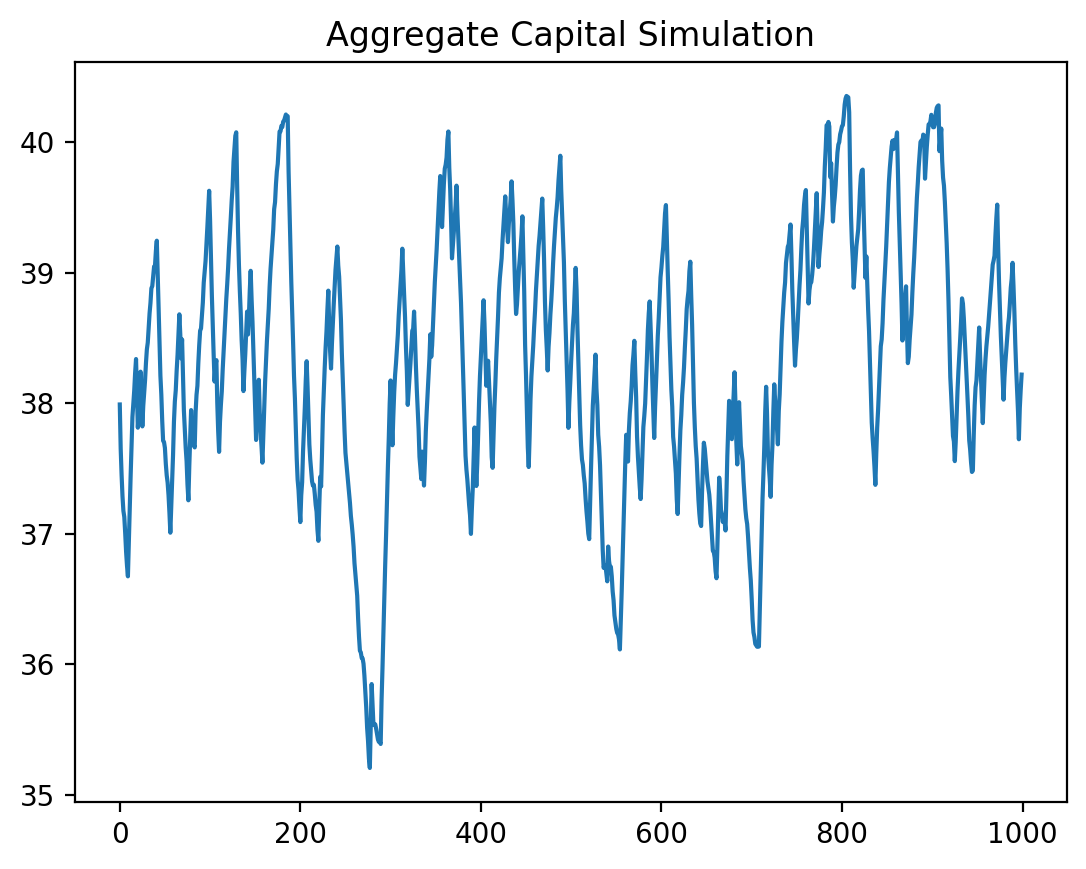

In [71]:
plt.plot(np.arange(0,T), Ks)
plt.title('Aggregate Capital Simulation')
plt.show()


## Step 6 Regression

- We use the simulated data to estimate parameters of ALM. 

In [72]:
# regress

index_b = np.where(ag_shock==0) # bad state
index1_b = np.array(index_b)+1 # next period
index_g = np.where(ag_shock==1) # good state
index1_g = np.array(index_g)+1 # next period
index1_g[index1_g==1000] = 999 # Prevent index out of range

# bad state

constant = np.ones((len(Ks[index_b]),1))
X = np.hstack((constant, Ks[index_b].reshape(len(Ks[index_b]),1)))
y = Ks[index1_b].reshape(len(Ks[index_b]),1)
reg = sm.OLS(y, X).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.174e+05
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:08:26   Log-Likelihood:                 625.87
No. Observations:                 451   AIC:                            -1248.
Df Residuals:                     449   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1036      0.104     20.164      0.0

In [73]:
# good state
constant = np.ones((len(Ks[index_g]),1))
X = np.hstack((constant, Ks[index_g].reshape(len(Ks[index_g]),1)))
y = Ks[index1_g].reshape(len(Ks[index_g]),1)
reg2 = sm.OLS(y, X).fit()
print(reg2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.266e+05
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:08:28   Log-Likelihood:                 946.34
No. Observations:                 549   AIC:                            -1889.
Df Residuals:                     547   BIC:                            -1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3506      0.076     30.761      0.0

## Coefficients of Actrual law of motion

In [74]:
print(f'New a0_b is {reg.params[0]}, and new a1_b is {reg.params[1]}')
print(f'New a0_g is {reg2.params[0]}, and new a1_g is {reg2.params[1]}')

New a0_b is 2.103629067997299, and new a1_b is 0.9403884935603088
New a0_g is 2.350577898640957, and new a1_g is 0.9425335544277138


## Conclusion

The coefficient of a1 is generally consistent with Krushell & Smith (1998), but the coefficient of a0 does not match. I speculate that this discrepancy may due to differences in interpolation methods and the selection of data for simulation.